# Analysis of the results of the simulation with the random node selection
Here, the graph presented in the chapter 2.5.1, that aims to show the simualtion results, is created. 

W tym pliku tworzę graf reprezentujący moją społeczność używając networkx, bo okazało się, że te moje klasy są gorsze.
Tworzę funkcje służące do symulowania epidemii i symuluję epidemie 1000 zarażająć jeden LOSOWY wierzchołek na początku, żeby zobaczyć jaka jest w ogóle szansa na rozprzestrzenie się epidemii. <br>

Symulacja bazuje na następujących założeniach <br>
1) Model SEIR- susceptible, exposed(infected but not infectious), infectious, recovered, <br>
2) istnieje czas inkubacji, wynosi 1 dzień, co rpawda kolejny jeszcze sie nie ma symptomów, ale już się zaraża, daltego przechodzi w ciągu jednego dnia z grupy exposed to infectious <br>
3) W grupie infectious jest w sumie 7 dni <br>
3) Prawdopodbieństwo zarażenia wynosi 0.006 <br>
4) Zakładam, że wszsystkie osoby w grupie są zdrowe i dorosłe, tylko wtedy ten czas inkubacji i bycia chorym jest poprawny<br>
Zasadniczo warto, by wprowadzić jakieś tam losowania tego czasu inkubacji i zarażania, ale tego nie robiłam....<br>

https://www.cdc.gov/flu/about/keyfacts.htm <br>

Zrobię symulację i policzę, jaka jest w ogóle szansa, że >=3 osoby wyjdą poza grupę S

In [1]:
#DANE+ BIBLIOTEKI
%store -r G 
import networkx as nx
import matplotlib.pyplot as plt
import random
import statistics
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

data=open("C:/Users/wojci/Documents/Studia/praca/dane.txt","r")
data=data.readlines()
contacts=[]
nodes=[]
times=[]
#OBRÓBKA DANYCH
for i in range(0,len(data)):
    row=data[i]
    row=row.split()
    nodes.append(int(row[1]))
    nodes.append(int(row[2]))
    times.append(int(row[0])/60/60/24)
nodes=set(nodes)
nodes=list(nodes)  #tak otrzymuję wszystkie wierzchołki jakie są w sieci podczas całego badania

for i in range(0,len(data)):
    row=data[i]
    row=row.split()
    contacts.append((int(row[0])//60/60/24,int(row[1]),int(row[2]))) #i teraz kontakty mamy w postaci (czas, node1,node2)

In [2]:
inf_prob=0.006
incubation_period=1
infectious_period=7

def clear_net():
    for i in list(G.nodes):
        G.nodes[i]['state']="S"
        G.nodes[i]['time_of_inf']=False
    G.graph['time']=0
    G.graph['E']=0
    G.graph['S']=92
    G.graph['I']=0
    G.graph['R']=0
    
def new_exposed(node,time):
    G.graph['E']+=1
    G.graph['S']-=1
    G.nodes[node]['state']='E'
    G.nodes[node]['time_of_inf']=time
    
def transformations():
    for i in list(G.nodes):
        #end of incubation
        if G.nodes[i]['state']=="E":
            if G.nodes[i]['time_of_inf']+incubation_period<=G.graph['time']:
                G.nodes[i]['state']="I"
                G.graph['E']-=1
                G.graph['I']+=1
            
        #end of infectiousness ->passing to recovered
        if G.nodes[i]['state']=='I':
            if G.nodes[i]['time_of_inf']+incubation_period+infectious_period<=G.graph['time']:
                G.nodes[i]['state']="R"
                G.nodes[i]['time_of_inf']=False
                G.graph['I']-=1
                G.graph['R']+=1

def new_contact(node1,node2,time):
    
    if G.nodes[node1]['state']=='I'and G.nodes[node2]['state']=='S':
        pr=random.random() 
        if pr<=inf_prob: #udało się zarazić
            G.nodes[node2]['state']='E'
            G.nodes[node2]['time_of_inf']=time
            G.graph['E']+=1
            G.graph['S']-=1
                
    if G.nodes[node2]['state']=='I'and G.nodes[node1]['state']=='S':
        pr=random.random() 
        if pr<=inf_prob: #udało się zarazić
            G.nodes[node1]['state']='E'
            G.nodes[node1]['time_of_inf']=time
            G.graph['E']+=1
            G.graph['S']-=1
            
def epidemics(node):
    S=[]
    E=[]
    I=[]
    R=[]
    clear_net()
    new_exposed(node,0)
    times=[G.graph['time']]
    
    for i in contacts:
        
        if times[-1]!=i[0]:
            G.graph['time']=i[0]
            transformations()
            times.append(G.graph['time'])
            var=True
            
        new_contact(i[1],i[2],i[0])
        
        if var==True:
            S.append(G.graph['S'])
            E.append(G.graph['E'])
            R.append(G.graph['R'])
            I.append(G.graph['I'])
        
            
    return [S,E,I,R]

def simple_epidemics(node): #used for MC simulation
    clear_net()
    new_exposed(node,0)
    for i in contacts:
        G.graph['time']=i[0]
        transformations()
        new_contact(i[1],i[2],i[0])
    return G.graph['S']

Symulacja Monte Carlo -1000 razy losuję dowolny wierzchołek i patrzę ile osób mu się uda wyprowadzić z grupy S

In [3]:
nodes_list=list(G.nodes)
N=1000
S_normal=[92-simple_epidemics(random.choice(nodes_list)) for j in range(0,N)] 
%store S_normal

Stored 'S_normal' (list)


(array([789.,  83.,  58.,  28.,  22.,  11.,   4.,   4.,   0.,   1.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

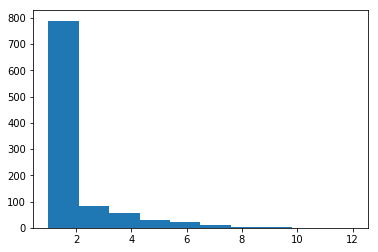

In [10]:
%store -r
plt.hist(S_normal)
#plt.title('Number of people out of S at the end of simulation')

'Number of people out of S at the end of simulation'

Jak widać w ogromnej liczbie przypadków (ok. 80 % nikogo nie udaje sie zarazić i i jedyną chorą osobą jest osoba, która została zainfekowana na początku symulacji-> epidemia się nie rozprzestrzenia)
W 83 przypadkach (ok 10%) udało sie epidemię komuś przekazać, szansa, że przekazana zostanie >= 2 osobom też wynosi ok. 10 %

In [1]:
"""%store -r S_normal
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
fig, ax = plt.subplots(1,1)
plt.hist(S_normal)
plt.ylabel('Frequency')
plt.xlabel('Number of secondary cases')
plt.title('Histogram of the number of secondary cases- random selection')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
a=plt.gcf()
a.savefig("C:/Users/wojci/Documents/Studia/praca/ZDEJCIA/random_selection/random_selection.eps")
plt.show()"""

'%store -r S_normal\nimport matplotlib.pyplot as plt\nimport matplotlib.ticker as plticker\nloc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals\nax.xaxis.set_major_locator(loc)\nfig, ax = plt.subplots(1,1)\nplt.hist(S_normal)\nplt.ylabel(\'Frequency\')\nplt.xlabel(\'Number of secondary cases\')\nplt.title(\'Histogram of the number of secondary cases- random selection\')\nloc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals\nax.xaxis.set_major_locator(loc)\na=plt.gcf()\na.savefig("C:/Users/wojci/Documents/Studia/praca/ZDEJCIA/random_selection/random_selection.eps")\nplt.show()'

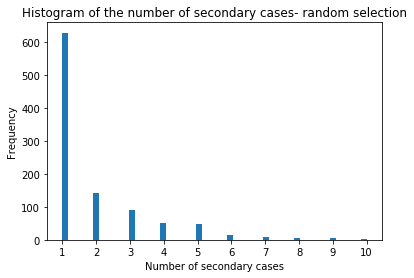

In [19]:
%store -r S_normal
import matplotlib.pyplot as plt
import numpy as np
plt.hist(S_normal,bins=50)
plt.ylabel('Frequency')
plt.xlabel('Number of secondary cases')
plt.title('Histogram of the number of secondary cases- random selection')
plt.xticks(np.arange(min(S_normal), max(S_normal)+1, 1.0))
a=plt.gcf()
a.savefig("C:/Users/wojci/Documents/Studia/praca/ZDEJCIA/random_selection/random_selection.eps")
plt.show()

In [36]:
hist,bin_edges=np.histogram(S_normal)

In [37]:
bin_edges = np.round(bin_edges,0)

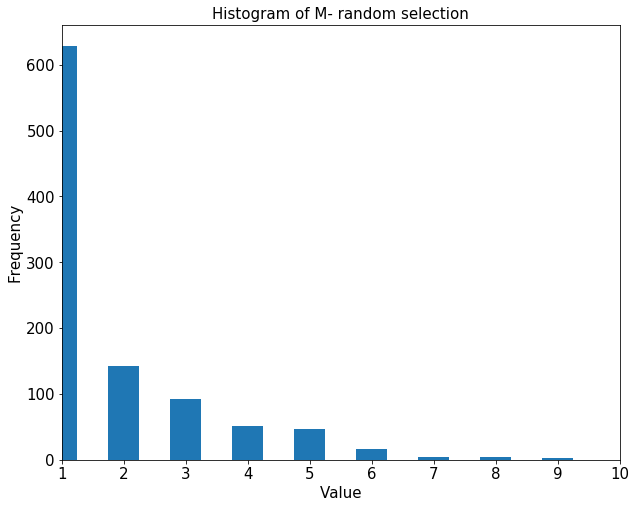

In [45]:
plt.figure(figsize=[10,8])
plt.bar(bin_edges[:-1], hist,color='#1f77b4', width = 0.5)#,alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
#plt.grid(axis='y', alpha=0.75)
f=15
plt.ylabel('Frequency',fontsize=f)
plt.xlabel('Value',fontsize=f)
plt.title('Histogram of M- random selection',fontsize=f)
plt.xticks(fontsize=f)
plt.yticks(fontsize=f)
a=plt.gcf()
a.savefig("C:/Users/wojci/Documents/Studia/praca/ZDEJCIA/random_selection/random_selection.eps")
plt.show()

(array([629., 143.,  92.,  52.,  47.,  16.,   9.,   5.,   4.,   3.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

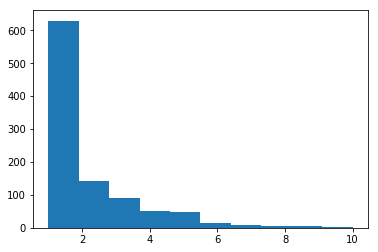

In [46]:
plt.hist(S_normal)